In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
"""
Tutorial: Predicting Diabetes Progression using a Multilayer Perceptron (MLP)

Overview:
This tutorial demonstrates how to predict a quantitative measure of diabetes progression using an MLP neural network.
We will cover data loading, preprocessing, model building with TensorFlow Keras, training with early stopping,
and evaluation using key regression metrics and multiple new visualizations (loss curves, scatter plots, residual plots,
and violin plots). The tutorial emphasizes teaching critical aspects of neural network design, model evaluation,
and interpretation of results.

Date: 3/27/2025
"""

# Set a new visual style (using fivethirtyeight style)
plt.style.use("fivethirtyeight")
sns.set_theme(style="whitegrid")

In [ ]:
# 1. Load and Explore the Diabetes Dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

In [ ]:
# Create a DataFrame for better visualization
df = pd.DataFrame(X, columns=diabetes.feature_names)
df['progression'] = y

print("Dataset shape:", df.shape)
print("\nDataset preview:")
df.head()

Dataset shape: (442, 11)

Dataset preview:


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [ ]:
# 2. Data Preprocessing
# Diabetes dataset features are already scaled, but we apply StandardScaler for demonstration.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42
)
print("\nTraining set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 353
Test set size: 89


In [ ]:
# 3. Build the MLP Model using Keras
def build_mlp_model(input_dim):
    model = Sequential([
        Dense(64, activation="relu", input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1)  # Regression output: continuous value
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

mlp_model = build_mlp_model(X_train.shape[1])
mlp_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# 4. Model Training
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
history = mlp_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - loss: 30090.5312 - val_loss: 22435.6016
Epoch 2/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 33388.1406 - val_loss: 22427.2363
Epoch 3/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 33553.1484 - val_loss: 22405.2754
Epoch 4/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 33576.8359 - val_loss: 22368.1777
Epoch 5/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 30644.9863 - val_loss: 22315.7168
Epoch 6/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 29654.0449 - val_loss: 22250.9727
Epoch 7/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 31904.0918 - val_loss: 22172.5020
Epoch 8/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 29418.8457 - val_loss: 22080.2422
Epoch 9/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 31819.8496 - val_loss: 21970.9766
Epoch 10/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 30609.3398 - val_loss: 21842.9023
Epoch 11/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 28893.8125 - val_loss: 

In [ ]:
# 5. Model Evaluation
y_pred = mlp_model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nTest MSE: {mse:.3f}")
print(f"Test R2 Score: {r2:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step

Test MSE: 3410.114
Test R2 Score: 0.356


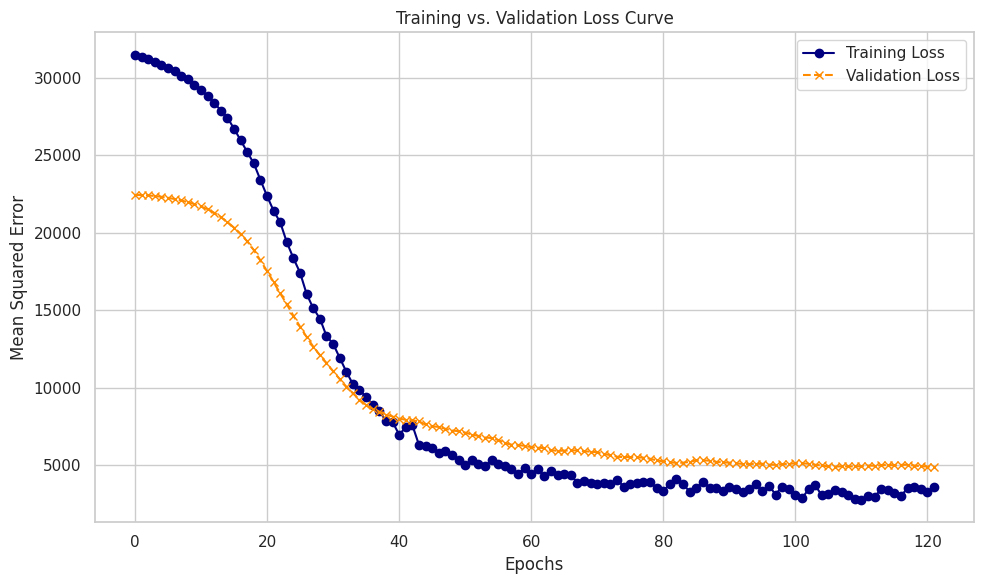

In [ ]:
# 6. Visualizations

# 6.1 Training and Validation Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], marker='o', linestyle='-', color='navy', label='Training Loss')
plt.plot(history.history['val_loss'], marker='x', linestyle='--', color='darkorange', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training vs. Validation Loss Curve")
plt.legend()
plt.tight_layout()
plt.show()


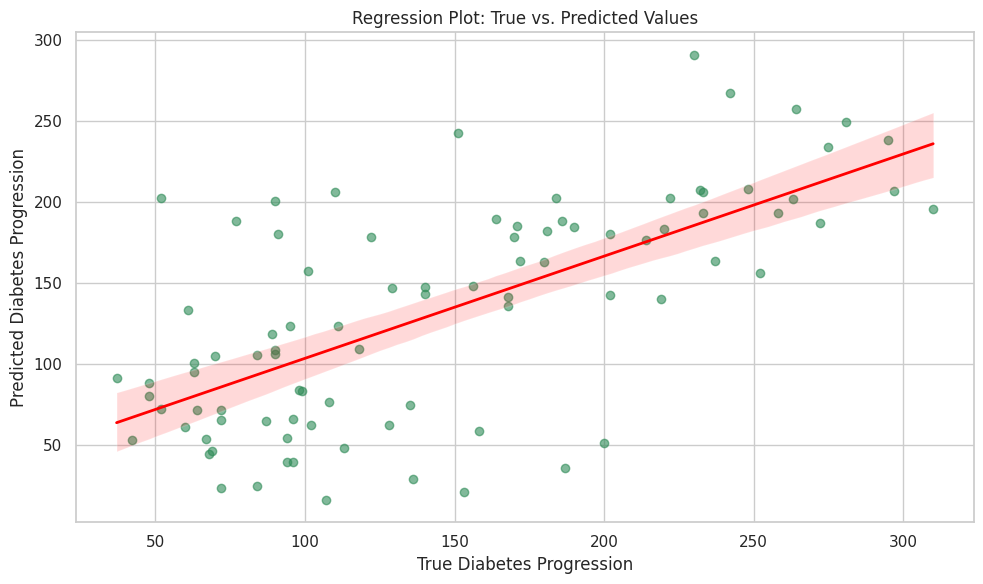

In [ ]:
# 6.2 Scatter Plot: True vs. Predicted Progression
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.6, 'color':'seagreen'}, line_kws={'color':'red', 'lw':2})
plt.xlabel("True Diabetes Progression")
plt.ylabel("Predicted Diabetes Progression")
plt.title("Regression Plot: True vs. Predicted Values")
plt.tight_layout()
plt.show()

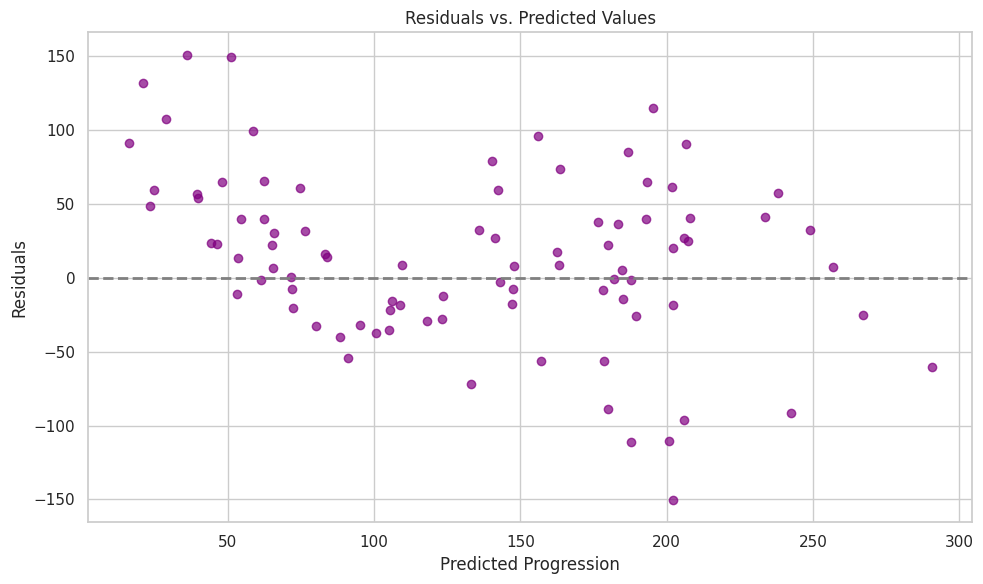

In [ ]:
# 6.3 Residual Analysis: Scatter and Histogram
residuals = y_test - y_pred

# Scatter plot of residuals vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.7)
plt.axhline(y=0, color='grey', linestyle='--', lw=2)
plt.xlabel("Predicted Progression")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.tight_layout()
plt.show()

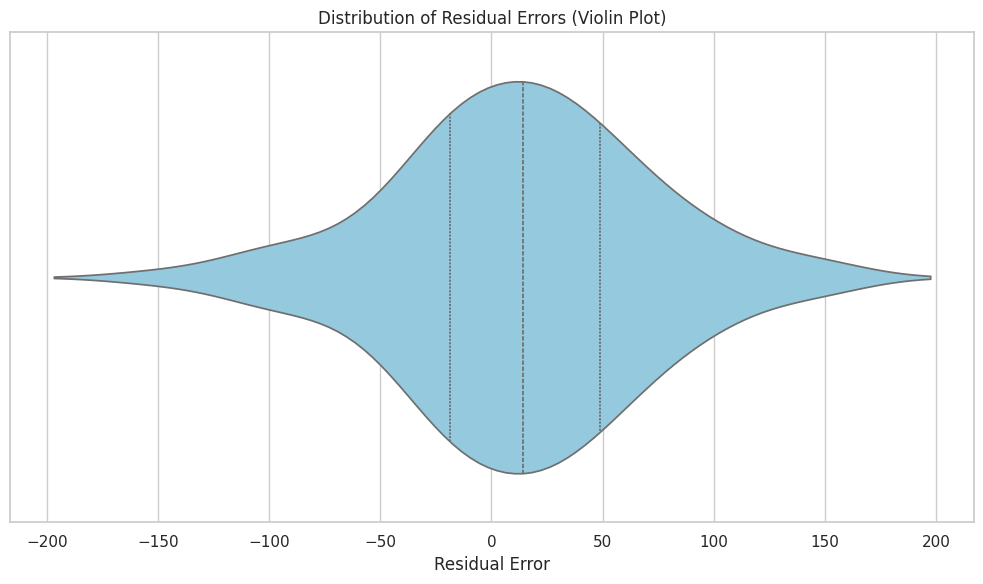

In [ ]:
# Histogram (with KDE) of residuals using a violin plot style
plt.figure(figsize=(10, 6))
sns.violinplot(x=residuals, inner="quartile", color="skyblue")
plt.xlabel("Residual Error")
plt.title("Distribution of Residual Errors (Violin Plot)")
plt.tight_layout()
plt.show()

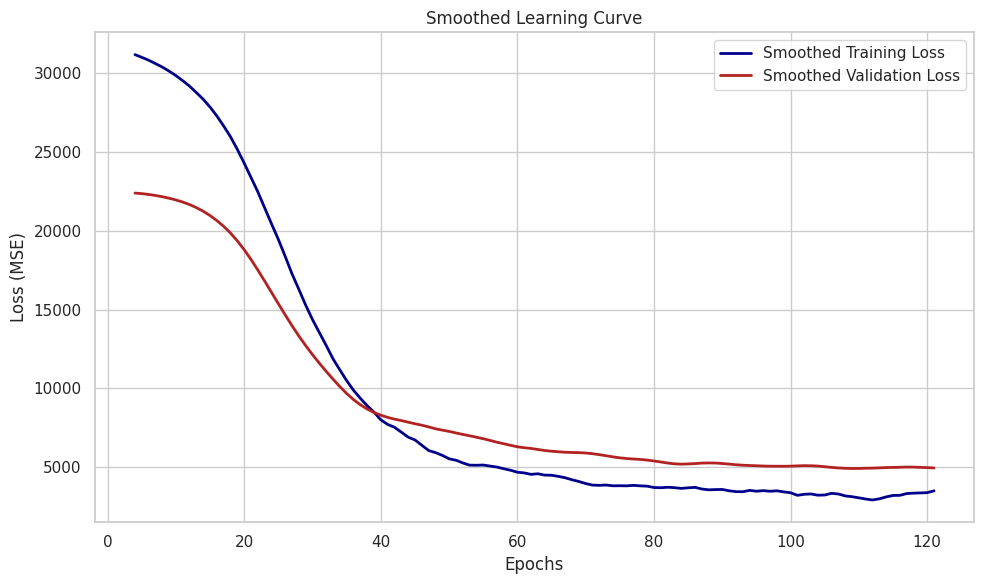

In [ ]:
# 6.4 Learning Curve: Plotting loss per epoch with a smoothed curve using rolling average
loss_df = pd.DataFrame(history.history)
loss_df['train_loss_smooth'] = loss_df['loss'].rolling(window=5).mean()
loss_df['val_loss_smooth'] = loss_df['val_loss'].rolling(window=5).mean()

plt.figure(figsize=(10, 6))
plt.plot(loss_df['train_loss_smooth'], label='Smoothed Training Loss', color='darkblue', linewidth=2)
plt.plot(loss_df['val_loss_smooth'], label='Smoothed Validation Loss', color='firebrick', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Smoothed Learning Curve")
plt.legend()
plt.tight_layout()
plt.show()